# Feature alignment to generalize models to unlabeled out-of-distribution samples (OODs) using Mean Squared Error (MSE) and Optimal Transport (OT).

## Showcase with MNIST and a simlpe CNN. This notebook assumes that (1) pairing between ID and ODD is unknown (by shuffling OODs). (2) few ODDs for learning feature alignment exist (only a batch of 32).

In [1]:
import torch
from torchvision.datasets import MNIST
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import utils # stores all utility/helper functions
from torch.utils.data import Subset
torch.manual_seed(0)
import random
random.seed(0)

### Simple CNN classifer, 2 convolutional and 2 dense layers which returns the learned representation layers list, and the prediction. 

In [2]:
model = utils.SimpleCNN()

### Reading dataset, and apply a guassian noise to add a distribution shift for OOD! 

In [3]:
dataset_train = MNIST(root = './minst_data/', download = True, train=True,transform = transforms.ToTensor())
dataset_test = MNIST(root = './minst_data/', download = True, train=False,transform = transforms.ToTensor())
        
transform_ood = transforms.Compose([
    transforms.ToTensor(),
    utils.add_gaussian_noise(std=0.7)
])
dataset_train_ood = MNIST(root = './minst_data/', download = True, train=True, transform = transform_ood)
dataset_test_ood  = MNIST(root = './minst_data/', download = True, train=False, transform = transform_ood)
dataset_train_odd_few  = Subset(dataset_train_ood, range(32)) # just try with a single batch of 32


### Visulaize IDs vs OODs!

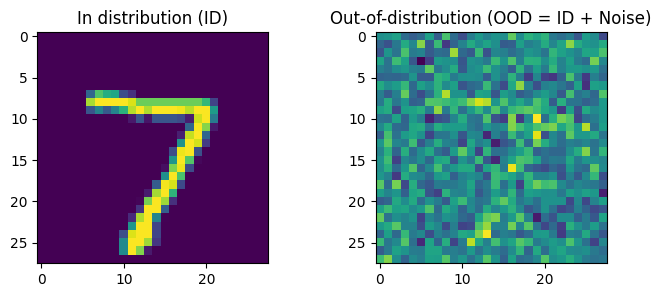

In [4]:
fig, ax   = plt.subplots(1,2, figsize=(8,3))
image_id  = next(iter(dataset_test))[0]
image_ood = next(iter(dataset_test_ood))[0]
ax[0].imshow(image_id[0,:])
ax[0].set_title("In distribution (ID)")
ax[1].imshow(image_ood[0,:])
ax[1].set_title("Out-of-distribution (OOD = ID + Noise)")
plt.show()

In [5]:
# define data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)


test_ood_loader    = torch.utils.data.DataLoader(dataset_test_ood,batch_size=batch_size)
train_ood_loader   = torch.utils.data.DataLoader(dataset_train_odd_few,batch_size=batch_size, shuffle=True)

### Pre-training with IDs

Start Training
epoch: 0, cross entropy loss -> ID training: 7.252e-03,  ID testing: 3.115e-03,  OOD testing: 3.747e-02 
                    Accuracy -> ID training: 0.930,      ID testing: 0.968,      OOD testing: 0.660
epoch: 1, cross entropy loss -> ID training: 2.194e-03,  ID testing: 3.485e-03,  OOD testing: 5.240e-02 
                    Accuracy -> ID training: 0.978,      ID testing: 0.965,      OOD testing: 0.597
epoch: 2, cross entropy loss -> ID training: 1.510e-03,  ID testing: 2.142e-03,  OOD testing: 5.692e-02 
                    Accuracy -> ID training: 0.985,      ID testing: 0.978,      OOD testing: 0.596
epoch: 3, cross entropy loss -> ID training: 1.105e-03,  ID testing: 1.352e-03,  OOD testing: 6.338e-02 
                    Accuracy -> ID training: 0.989,      ID testing: 0.985,      OOD testing: 0.569
epoch: 4, cross entropy loss -> ID training: 8.381e-04,  ID testing: 1.180e-03,  OOD testing: 7.191e-02 
                    Accuracy -> ID training: 0.992,      ID 

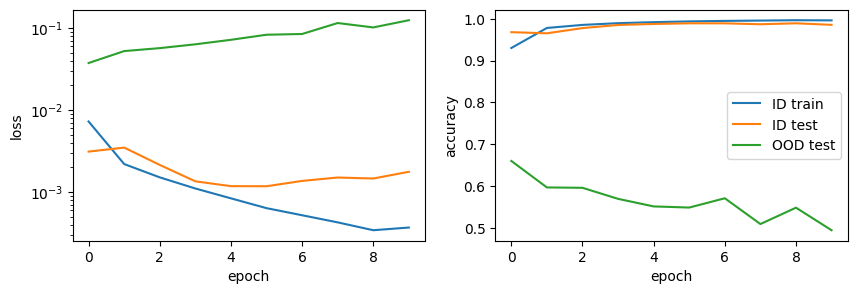

In [6]:
training_accuracy, training_loss = [], [] 
testing_accuracy, testing_loss = [], [] 
OOD_accuracy, OOD_loss = [], [] 
print('Start Training')

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.e-3)

for epoch_index in range(10):  # loop over the dataset multiple times

    ########################################### TRAINING LOOP ########################################################
    train_loss, train_accuracy =  utils.train_one_epoch(model, train_loader, loss_fn, optimizer)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss)
   
    ########################################### TESTING LOOP ########################################################
    test_loss, test_accuracy = utils.test_one_epoch(model, test_loader,loss_fn)    
    testing_accuracy.append(test_accuracy)
    testing_loss.append(test_loss)  
    ################################################################################################################
    ood_loss, ood_accuracy = utils.test_one_epoch(model, test_ood_loader,loss_fn) 
    OOD_accuracy.append(ood_accuracy)
    OOD_loss.append(ood_loss)  

    print('epoch: {}, cross entropy loss -> ID training: {:.3e},  ID testing: {:.3e},  OOD testing: {:.3e} '.format(epoch_index,train_loss, test_loss,ood_loss))
    print ('                    Accuracy -> ID training: {:0.3f},      ID testing: {:0.3f},      OOD testing: {:0.3f}'.format(train_accuracy,test_accuracy,ood_accuracy))
    ################################################################################################################

    

print('Finished Training')

fig = plt.figure(figsize=(10,3))
fig.add_subplot(121)   #top left
plt.semilogy(training_loss)
plt.semilogy(testing_loss)
plt.semilogy(OOD_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
fig.add_subplot(122)   #top right
plt.plot(training_accuracy, label='ID train')
plt.plot(testing_accuracy,label='ID test')
plt.plot(OOD_accuracy,label='OOD test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Feature alignment using MSE and Optimal Transport (OT)

### Now let's assume that we do not have labels for the OOD samples, and we want to improve the OOD accuracy through feature aligenment

In [7]:
# copy model for MSE and OT
model_mse = utils.SimpleCNN()
model_mse.load_state_dict(model.state_dict())

model_ot = utils.SimpleCNN()
model_ot.load_state_dict(model.state_dict())


<All keys matched successfully>

In [8]:
# check whether the model copy give same accuracy as the pretrained model!
pre_trained_model = utils.test_one_epoch(model, test_loader,loss_fn)
copy_for_MSE      = utils.test_one_epoch(model_mse, test_loader,loss_fn)
copy_for_OT       = utils.test_one_epoch(model_ot, test_loader,loss_fn)

if pre_trained_model[0] == copy_for_MSE[0] ==copy_for_OT[0] and pre_trained_model[1] == copy_for_MSE[1] ==copy_for_OT[1]:
    print ("Successful copy!")

Successful copy!


### Let's use MSE and OT to minimize the distance between ID and OOD at the level of the learned representation starting from the pretrained model

In [ ]:
testing_accuracy, testing_loss = [], [] 
training_mse_accuracy, training_mse_loss = [], [] 
training_ot_accuracy, training_ot_loss = [], [] 

# give equal weights for OT
weights = torch.ones(batch_size) / batch_size

layer_index = range(4) # for using all 4 layers, if [0,3] then compute the loss for the first and fourth layers only

OOD_mse_accuracy, OOD_mse_loss = [], [] 
OOD_ot_accuracy, OOD_ot_loss = [], [] 
print('Start learning feature aligment between ID and OOD!')
optimizer_mse = optim.Adam(model_mse.parameters(), lr=1.e-3)
optimizer_ot = optim.Adam(model_ot.parameters(), lr=1.e-3)
align_mse_loss = nn.MSELoss()
for epoch_index in range(100):  # loop over the dataset multiple times

    # testing loop for ID, always the same 
    test_loss, test_accuracy = utils.test_one_epoch(model, test_loader,loss_fn)    
    testing_accuracy.append(test_accuracy)
    testing_loss.append(test_loss)  

    # testing the OOD accuracy from model_mse (e.g. using MSE for feature alignment!)
    ood_mse_loss, ood_mse_accuracy = utils.test_one_epoch(model_mse, test_ood_loader,loss_fn) 
    OOD_mse_accuracy.append(ood_mse_accuracy)
    OOD_mse_loss.append(ood_mse_loss)  

    # testing the OOD accuracy from model_ot (e.g. using OT for feature alignment!)
    ood_ot_loss, ood_ot_accuracy = utils.test_one_epoch(model_ot, test_ood_loader,loss_fn) 
    OOD_ot_accuracy.append(ood_ot_accuracy)
    OOD_ot_loss.append(ood_ot_loss)  


    # feature alignment training using MSE
    train_mse_loss, train_mse_accuracy =  utils.align_representation_mse(model, model_mse, train_loader,  train_ood_loader,align_mse_loss, optimizer_mse, layer_index)
    training_mse_accuracy.append(train_mse_accuracy)
    training_mse_loss.append(train_mse_loss)

    # feature alignment training using OT
    train_ot_loss, train_ot_accuracy =  utils.align_representation_ot(model, model_ot, train_loader,  train_ood_loader, optimizer_ot,weights, layer_index)
    training_ot_accuracy.append(train_ot_accuracy)
    training_ot_loss.append(train_ot_loss)

    print ('epoch: {}'.format(epoch_index))
    print ('ID  testing cross entropy loss: from pre-trained model: {:.3e}, accuracy: {:.3f}'.format(test_loss, test_accuracy))
    print ('OOD testing cross entropy loss: from feature alignment with MSE: {:.3e}, accuracy: {:.3f}'.format(ood_mse_loss,ood_mse_accuracy))
    print ('OOD testing cross entropy loss: from feature alignment with OT:  {:.3e}, accuracy: {:.3f}'.format(ood_ot_loss,ood_ot_accuracy))
    print ('OOD feature alignment MSE loss: {:.3e}, accuracy: {:.3f}'.format(train_mse_loss,train_mse_accuracy))
    print ('OOD feature alignment OT  loss: {:.3e}, accuracy: {:.3f}'.format(train_ot_loss,train_ot_accuracy))
    
  
print('Finished Training')

Start learning feature aligment between ID and OOD!
epoch: 0
ID  testing cross entropy loss: from pre-trained model: 1.767e-03, accuracy: 0.985
OOD testing cross entropy loss: from feature alignment with MSE: 1.261e-01, accuracy: 0.496
OOD testing cross entropy loss: from feature alignment with OT:  1.248e-01, accuracy: 0.496
OOD feature alignment MSE loss: 8.122e+00, accuracy: 0.531
OOD feature alignment OT  loss: 5.739e+01, accuracy: 0.500
epoch: 1
ID  testing cross entropy loss: from pre-trained model: 1.767e-03, accuracy: 0.985
OOD testing cross entropy loss: from feature alignment with MSE: 1.183e-01, accuracy: 0.497
OOD testing cross entropy loss: from feature alignment with OT:  1.128e-01, accuracy: 0.521
OOD feature alignment MSE loss: 6.987e+00, accuracy: 0.500
OOD feature alignment OT  loss: 5.775e+01, accuracy: 0.469
epoch: 2
ID  testing cross entropy loss: from pre-trained model: 1.767e-03, accuracy: 0.985
OOD testing cross entropy loss: from feature alignment with MSE: 1.1

### Plot loss and accuracy during learning feature alignment

In [ ]:
fig = plt.figure(figsize=(10,3))
fig.add_subplot(121)   #top left
plt.semilogy(testing_loss, label='ID test')
plt.semilogy(OOD_mse_loss, label='OOD test through feature alignment with MSE')
plt.semilogy(OOD_ot_loss, label='OOD test through feature alignment with OT')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
fig.add_subplot(122)   #top right
plt.plot(testing_accuracy)
plt.plot(OOD_mse_accuracy)
plt.plot(OOD_ot_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

### By minimizing the distance between the learning representation (i.e. layers output) between ID and OOD using either OT, the pre-trained model is able generalize to OODs and improve the accuracy from accuracy of ~0.5 to ~0.8  (by ~ 30%).

In [ ]:
categories = ['pre-trained (ID)', 'pre-trained (OOD)', 'using MSE (OOD)', 'unsing OT (OOD)']
values = [testing_accuracy[-1],OOD_mse_accuracy[0], OOD_mse_accuracy[-1], OOD_ot_accuracy[-1]]
fig, ax = plt.subplots(figsize=(10,3))
colors = ['lightblue','lightcoral', 'lightgrey', 'grey']
ax.bar(categories, values, color=colors,  hatch=['', '', '', ''])
ax.set_title('Feature Alignment for Out-of-Distribution (OOD=ID+Noise) generalization without using labels',fontsize=14)
for i in range(4):
    ax.axhline(y=values[i], color=colors[i], ls='dashed')

ax.arrow(1., 0.52, 0.0, 0.1, width=0.05, head_width=0.12,head_length=0.06, color='tab:blue')
ax.text(.52,.7,'feature alignment', fontsize=16, color='tab:blue')
ax.set_xlabel('MNIST',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim([0.0,1.0])
plt.tight_layout()
plt.show()

### Awesome! The feature alightment with OT works but with MSE does not, when pairing between ID and OODs is unknown, through the random shuffling for only OOD batch of 32.  Next steps will be to assume and fewer OODs for one single class exist. Stay tuned!